# Random Binary Vector Projection of Environments: Reward Estimation

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we explore using random binary vectors as representations of states.
This method applies to environments with discrete states.
Given a dimension $d$, we generate a vector $x$ that has at most $\frac{d}{2}$ of its values set to one.
The indices that are set to one are chosen at random, from a uniform distribution.


In [1]:
import math

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
from scipy import linalg

In [3]:
from rlplg.environments import gridworld, iceworld, redgreen

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

## Reward Estimation

In [5]:
def solve_least_squares(matrix: np.ndarray, rhs: np.ndarray) -> np.ndarray:
    try:
        solution, _, _, _ = np.linalg.lstsq(matrix, rhs, rcond=None)
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [6]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

In [7]:
def collection_traj_data(env: gym.Env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        (
            next_obs,
            rew,
            term,
            trunc,
            _,
        ) = env.step(action)
        step += 1
        buffer.append((obs, action, next_obs, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

## Gym Env

In [8]:
def delay_reward_data(buffer, delay: int, sample_size: int):
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[3] for example in buffer])
    states = np.concatenate(
        [
            np.stack([example[0] for example in buffer]),
            np.stack([example[2] for example in buffer]),
        ],
        axis=1,
    )

    # repr: (m1,a1)(m2,a1)..
    obs_dim = math.floor(states.shape[1] / 2)
    mdim = obs_dim * len(np.unique(action)) + obs_dim

    # build samples
    mask = np.random.choice(states.shape[0], (sample_size, delay))
    delayed_obs = states[mask]  # batch x delay x dim
    delayed_act = action[mask]  # batch x delay
    delayed_rew = np.sum(reward[mask], axis=1)  # batch x delay -> batch

    rhat_matrix = np.zeros(shape=(sample_size, mdim))

    # Vectorized operations for building rhat_matrix
    # Create indices for the action-based offsets
    action_offsets = delayed_act * obs_dim
    batch_indices = np.arange(sample_size)[:, None]

    # For each timestep in delay sequence
    for j in range(delay):
        # Split current states into obs and next_obs
        obs = delayed_obs[:, j, :obs_dim]
        next_obs = delayed_obs[:, j, obs_dim:]

        # Add obs to action-specific columns
        col_indices = action_offsets[:, j, None] + np.arange(obs_dim)
        rhat_matrix[batch_indices, col_indices] += obs

        # Add next_obs to final columns
        rhat_matrix[:, -obs_dim:] += next_obs
    return rhat_matrix, delayed_rew

In [9]:
def proj_obs_to_rwest_vec(buffer, sample_size: int):
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[3] for example in buffer])
    states = np.concatenate(
        [
            np.stack([example[0] for example in buffer]),
            np.stack([example[2] for example in buffer]),
        ],
        axis=1,
    )

    # repr: (m1,a1)(m2,a1)..
    obs_dim = math.floor(states.shape[1] / 2)
    mdim = obs_dim * len(np.unique(action)) + obs_dim

    # build samples
    mask = np.random.choice(states.shape[0], sample_size)
    delayed_obs = states[mask]  # batch x dim
    delayed_act = action[mask]
    delayed_rew = reward[mask]  # batch x delay -> batch

    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))

    # Vectorized operations for building rhat_matrix
    # Create indices for the action-based offsets
    action_offsets = delayed_act * obs_dim
    batch_indices = np.arange(len(delayed_obs))[:, None]

    # Add obs to action-specific columns
    col_indices = action_offsets[:, None] + np.arange(obs_dim)
    rhat_matrix[batch_indices, col_indices] += delayed_obs[:, :obs_dim]

    # Add next_obs to final columns
    rhat_matrix[:, -obs_dim:] += delayed_obs[:, obs_dim:]
    return rhat_matrix, delayed_rew

In [10]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int):
    buffer = collection_traj_data(env, steps=num_steps)
    Xd, yd = delay_reward_data(buffer, delay=delay, sample_size=sample_size)
    return buffer, solve_least_squares(Xd, yd)

In [11]:
def rwe_scatterplot(v_pred, v_true, title: str):
    _, ax = plt.subplots(figsize=(6, 6))
    df = pd.DataFrame({"x": v_pred, "y": v_true, "size": np.abs(v_pred - v_true)})
    delta = np.abs(v_pred - v_true)
    print("abs", np.max(delta), np.mean(delta), np.min(delta))
    sns.scatterplot(df, x="x", y="y", size="size", hue="size", color=".15", ax=ax)
    ax.set_xlabel("yhat")
    ax.set_ylabel("ytrue")
    ax.set_title(f"Reward Estimation: {title}")

abs 0.9998888543510284 0.5011965072017006 0.0001253733499539944


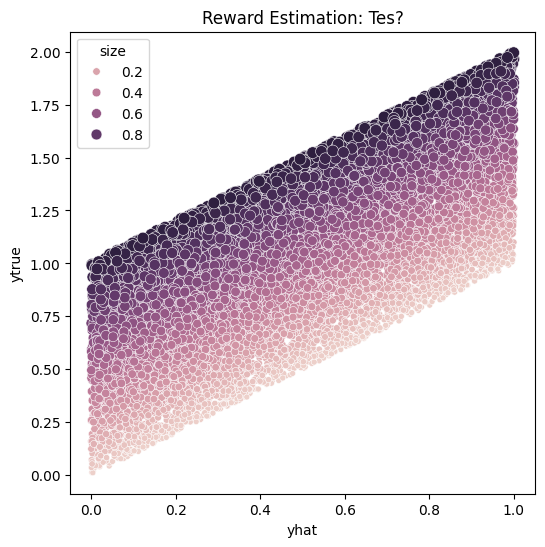

In [12]:
xs = np.random.random(10000)
ys = np.random.random(10000)
zs = xs + ys
rwe_scatterplot(xs, zs, "Tes?")

In [13]:
class RandomBinaryObsWrapper(gym.ObservationWrapper):
    def __init__(self, env: gym.Env, enc_size: int):
        super().__init__(env)
        self.obs_space = env.observation_space
        self.enc_size = enc_size
        self._representations = {}

        if not isinstance(env.observation_space, (gym.spaces.Box, gym.spaces.Discrete)):
            raise ValueError(
                f"Environment space must be either Box or Discrete, not {type(env.observation_space)}"
            )

    def observation(self, observation):
        array = np.array(observation, dtype=np.int64)
        if np.shape(array) == ():
            key = array.item()
        else:
            key = tuple(array.tolist())
        if key not in self._representations:
            indices = np.random.randint(
                0,
                high=self.enc_size,
                size=math.floor(self.enc_size / 2),
            )
            vec = np.zeros(shape=self.enc_size)
            vec[indices] = 1
            self._representations[key] = vec
        return self._representations[key]

### Grid World (Different Rewards)

In [14]:
class GridWorldObsAsVectorWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            high=np.array(
                [
                    env.observation_space["agent"][0].n,
                    env.observation_space["agent"][1].n,
                ]
            ),
            low=np.zeros(shape=2, dtype=np.int32),
        )

    def observation(self, observation):
        return np.array(observation["agent"])

In [17]:
def estimate_rewards(name: str, env: gym.Env, enc_sizes, turns: int = 10):
    if turns < 1:
        raise ValueError(f"Turns must be > 1. Got {turns}")
    results = []
    for enc_size in enc_sizes:
        print("Binary encoding size:", enc_size)
        for _ in range(turns):
            wrapped_env = RandomBinaryObsWrapper(env, enc_size=enc_size)
            buffer, sol = solve_rwe(
                wrapped_env,
                num_steps=150_000,
                sample_size=50_000,
                delay=2,
            )
            eval_X, eval_y = proj_obs_to_rwest_vec(buffer, sample_size=10_000)
            v_pred = np.matmul(eval_X, sol)
            error = rmse(v_pred=v_pred, v_true=eval_y, axis=0)
            results.append({"enc_size": enc_size, "rmse": error, "solution": sol})
        # last example
        rwe_scatterplot(
            v_pred=v_pred, v_true=eval_y, title=f"Example {name}, $d={enc_size}$"
        )

    return pd.DataFrame(results)

(4, 12) [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)] [(3, 11)] (3, 0)
Binary encoding size: 4
abs 69.55290576455545 13.178068762195693 0.2765299816915636
Binary encoding size: 8
abs 99.85354539448817 8.967275932212942 0.08629439996734756
Binary encoding size: 16
abs 75.11690571256888 5.617558413940537 0.008230761599412162
Binary encoding size: 32
abs 6.31317220722849e-12 9.632003639126197e-13 2.6645352591003757e-15


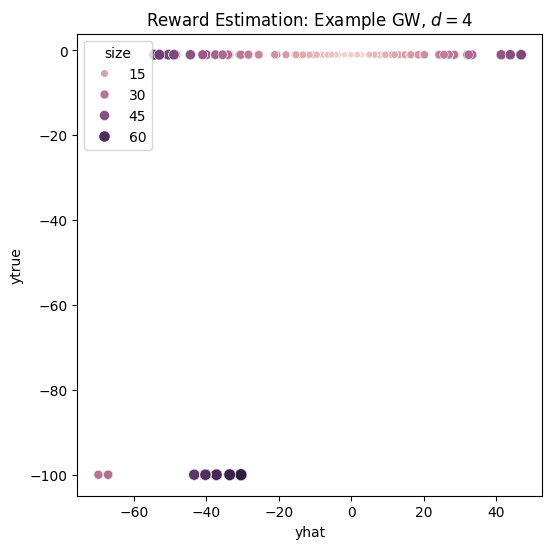

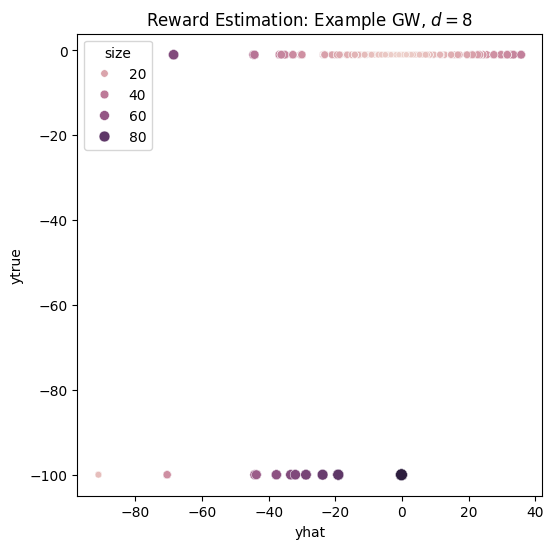

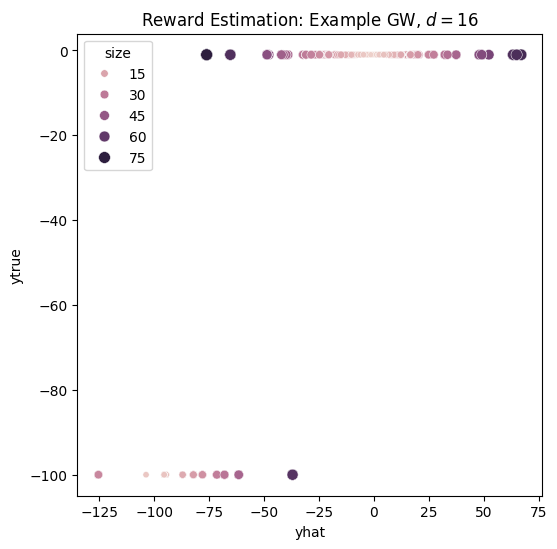

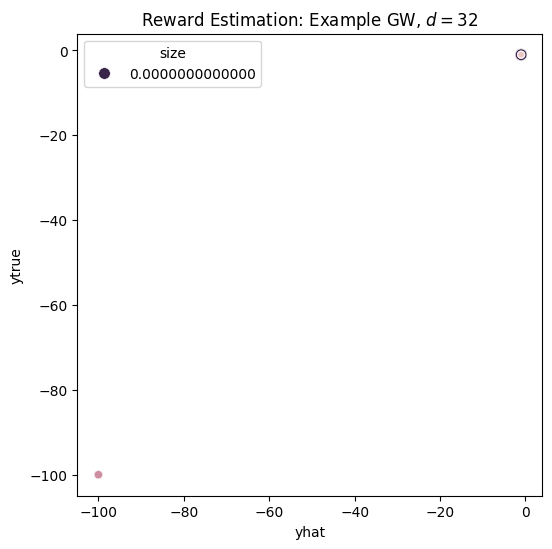

In [18]:
size, cliffs, exits, start = gridworld.parse_grid_from_text(
    ["oooooooooooo", "oooooooooooo", "oooooooooooo", "sxxxxxxxxxxg"]
)
print(size, cliffs, exits, start)
gw_env = GridWorldObsAsVectorWrapper(gridworld.GridWorld(size, cliffs, exits, start))
df_gw = estimate_rewards("GW", gw_env, enc_sizes=[2**k for k in range(2, 6)])

In [19]:
df_gw.head()

,enc_size,rmse,solution
0,4,15.443478,"[18.268002465774206, 6.956595729939994, 29.575..."
1,4,18.329559,"[-4.111195733657386, 5.462777535800157, 10.042..."
2,4,16.616267,"[-4.6943929067778685, -5.3135856959221, 7.9591..."
3,4,18.891042,"[-0.5482712233658378, 9.323050457557835, 1.480..."
4,4,17.645724,"[5.5365980937216035, 0.26335378853220703, 11.3..."


In [20]:
df_gw[["enc_size", "rmse"]].groupby("enc_size").mean().reset_index()

,enc_size,rmse
0,4,1.845732e+01
1,8,1.365707e+01
2,16,6.788417e+00
3,32,2.049275e-12


At $d=32$, the error becomes negligible.

### RedGreen

In [21]:
class RedgreenObsAsVectorWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            high=np.array([env.observation_space["pos"].n]), low=np.array([0])
        )

    def observation(self, observation):
        return np.array([observation["pos"]])

Binary encoding size: 4
abs 7.998046669399628e-13 4.0639069887049573e-13 8.43769498715119e-15
Binary encoding size: 8
abs 5.861977570020827e-14 1.8437318338726528e-14 8.881784197001252e-16
Binary encoding size: 16
abs 2.5757174171303632e-14 7.569422866282593e-15 3.3306690738754696e-16
Binary encoding size: 32
abs 2.864375403532904e-14 1.1182343939708516e-14 0.0
CPU times: user 1min 35s, sys: 2min 13s, total: 3min 48s
Wall time: 46.6 s


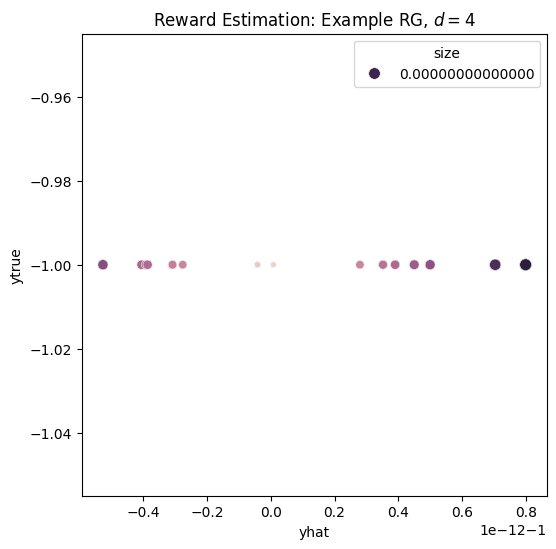

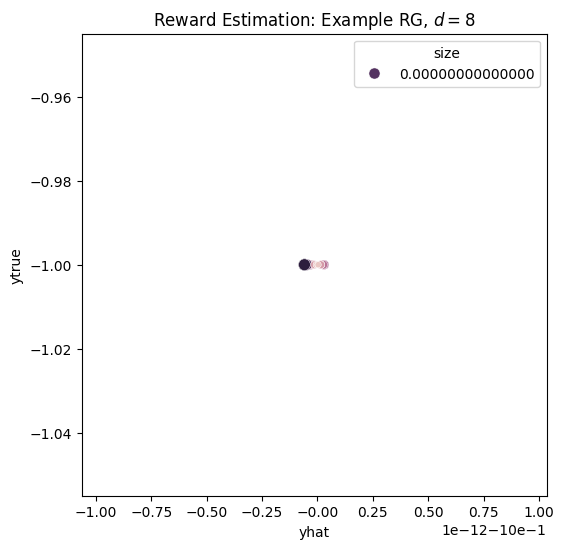

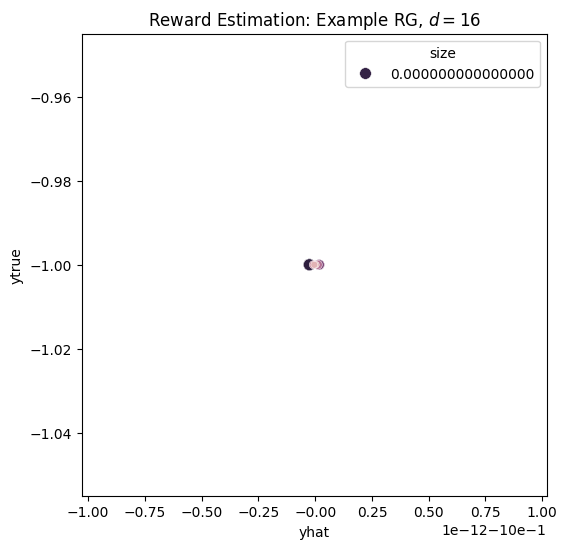

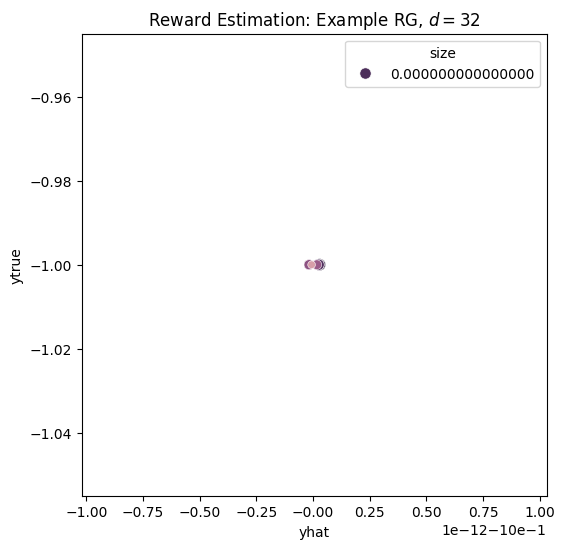

In [22]:
%%time
rg_env = RedgreenObsAsVectorWrapper(
    redgreen.RedGreenSeq(["red", "green", "red", "green", "wait", "green"])
)
df_rg = estimate_rewards("RG", rg_env, enc_sizes=[2**k for k in range(2, 6)])

In [23]:
df_rg.head()

,enc_size,rmse,solution
0,4,0.088442,"[0.13119046959315542, 0.25878828360498884, 0.1..."
1,4,0.135452,"[-0.33366172056343785, -0.00018227881242716126..."
2,4,0.154404,"[-0.27211594122043425, -0.1532203681240959, -3..."
3,4,0.221671,"[0.0651939868837914, -0.6010319034692858, -6.6..."
4,4,0.235188,"[-0.46498695480478924, -0.10490533159828053, -..."


In [24]:
df_rg[["enc_size", "rmse"]].groupby("enc_size").mean().reset_index()

,enc_size,rmse
0,4,1.063012e-01
1,8,2.111261e-14
2,16,1.152381e-14
3,32,1.244279e-14


Here, the results are also optimistic, even at smaller encoding sizes.

### Ice World

In [25]:
class IceworldObsAsVectorWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            high=np.array(
                [
                    env.observation_space["agent"][0].n,
                    env.observation_space["agent"][1].n,
                ]
            ),
            low=np.zeros(shape=2, dtype=np.int32),
        )

    def observation(self, observation):
        return np.array(observation["agent"])

(4, 4) [(1, 1), (1, 3), (2, 3), (3, 0)] [(3, 3)] (0, 0)
Binary encoding size: 4
abs 28.255406523758484 2.9456436187917587 0.08897634788413278
Binary encoding size: 8
abs 11.837727443639228 0.6456081832440496 0.0013313851263205834
Binary encoding size: 16
abs 1.2292389328649733e-12 3.220112620994087e-13 1.021405182655144e-14
Binary encoding size: 32
abs 5.968558980384842e-13 1.3223759864899876e-13 1.7763568394002505e-14


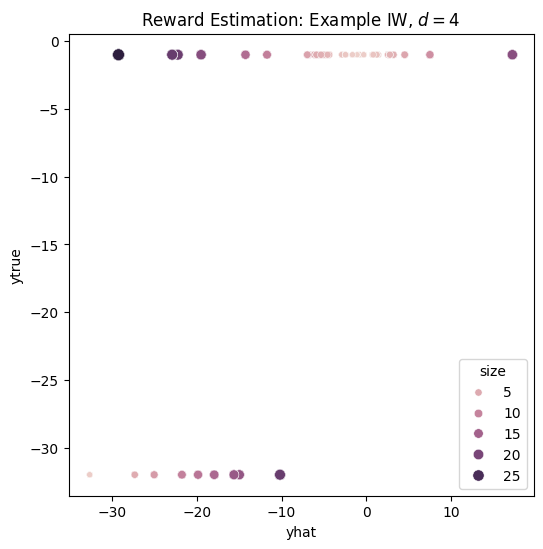

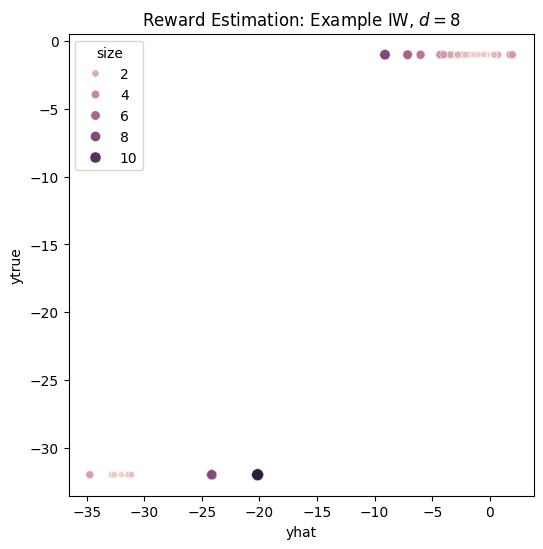

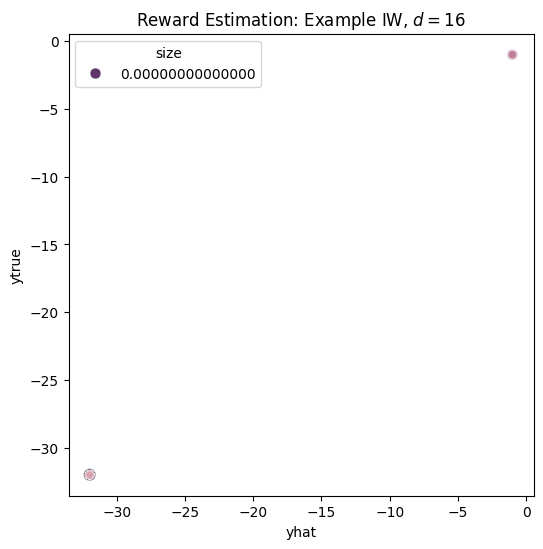

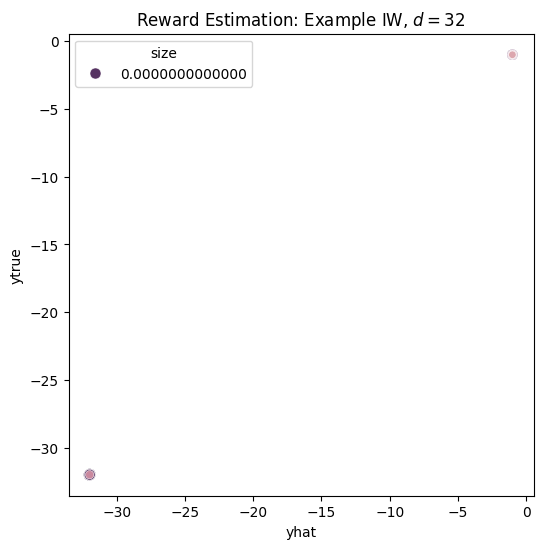

In [26]:
size, lakes, goals, start = iceworld.parse_map_from_text(iceworld.MAPS["4x4"])
print(size, lakes, goals, start)
iw_env = IceworldObsAsVectorWrapper(iceworld.IceWorld(size, lakes, goals, start))
df_iw = estimate_rewards("IW", iw_env, enc_sizes=[2**k for k in range(2, 6)])

## Conclusions

  - Binary random vectors show robust performance in reward estimation with these simple discrete environments